In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import tushare as ts
%matplotlib inline   

# 无视warning
import warnings
warnings.filterwarnings("ignore")

# 正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

#起始和结束日期可以自行输入，否则使用默认
def get_data(code, start_date, end_date):
    # 配置 tushare token
    my_token = '039660346bc8f4ad98c1b7b28fbbbb7750a6c6eea62573ff80a42593'
    pro = ts.pro_api(my_token)

    df = pro.daily(ts_code=code, start_date=start_date, end_date=end_date)
    df.index = pd.to_datetime(df.trade_date)

    return df.close

#以上证综指、贵州茅台、工商银行、中国平安为例
stocks={
    '600519.SH':'贵州茅台',
    '601398.SH':'工商银行',
    '601318.SH':'中国平安'

}

df = pd.DataFrame()
for code,name in stocks.items():
    df[name] = get_data(code, '20180101', '20221231')

# 按照日期正序
df = df.sort_index()

# 本地读入沪深300合并
df_base = pd.read_csv('/Users/jin/Downloads/000300.XSHG_2018_2022.csv')
df_base.index = pd.to_datetime(df_base.trade_date)
df['沪深300'] = df_base['close']

<AxesSubplot:xlabel='trade_date'>

Text(0.5, 1.0, '股价净值走势')

([<matplotlib.axis.XTick at 0x7feed15a1040>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

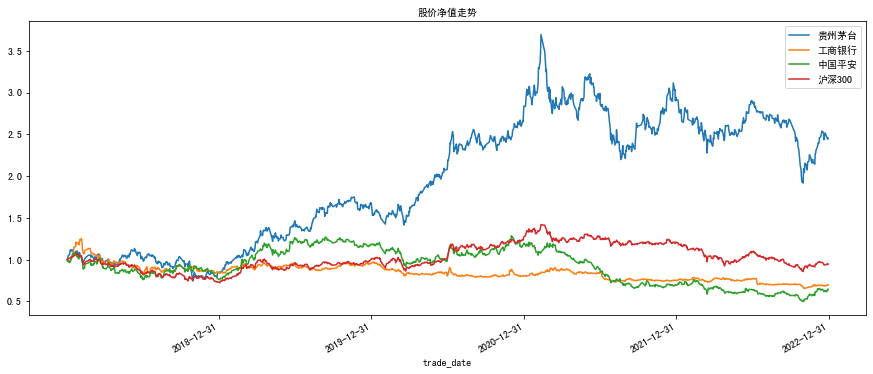

In [2]:
# 以第一交易日2018年1月1日收盘价为基点，计算净值并绘制净值曲线
df_worth = df / df.iloc[0]
df_worth.plot(figsize=(15,6))
plt.title('股价净值走势', fontsize=10)
plt.xticks(pd.date_range('20180101','20221231',freq='Y'),fontsize=10)
plt.show()

In [3]:
# 区间累计收益率(绝对收益率)
total_return = df_worth.iloc[-1]-1
total_return = pd.DataFrame(total_return.values,columns=['累计收益率'],index=total_return.index)
total_return

# 年化收益率
annual_return = pd.DataFrame((1 + total_return.values) ** (252 / 1826) - 1,columns=['年化收益率'],index=total_return.index)
annual_return

,累计收益率
贵州茅台,1.453648
工商银行,-0.297735
中国平安,-0.352528
沪深300,-0.052789


,年化收益率
贵州茅台,0.131870
工商银行,-0.047607
中国平安,-0.058225
沪深300,-0.007457


In [4]:
df_return = df / df.shift(1) - 1
df_return = ((df_return.iloc[1:] - df_return.mean()) ** 2)

volatility = pd.DataFrame(np.sqrt(df_return.sum() * 252 / (1826-1)),columns=['波动率'],index=total_return.index)
volatility

,波动率
贵州茅台,0.267357
工商银行,0.148130
中国平安,0.233149
沪深300,0.168623


In [5]:
def max_drawdown_cal(df):
    md = ((df.cummax() - df)/df.cummax()).max()
    return round(md, 4)

max_drawdown = {}

stocks={
    '600519.SH':'贵州茅台',
    '601398.SH':'工商银行',
    '601318.SH':'中国平安',
    '000300.XSHG': '沪深300'
}

for code,name in stocks.items():
    max_drawdown[name]=max_drawdown_cal(df[name])

max_drawdown = pd.DataFrame(max_drawdown,index=['最大回撤']).T
max_drawdown

,最大回撤
贵州茅台,0.4810
工商银行,0.4761
中国平安,0.6129
沪深300,0.3959


In [6]:
from scipy import stats

#计算每日收益率 收盘价缺失值（停牌），使用前值代替
rets=(df.iloc[:,:4].fillna(method='pad')).apply(lambda x:x/x.shift(1)-1)[1:]

#市场指数为x，个股收益率为y
x = rets.iloc[:,3].values
y = rets.iloc[:,:3].values
capm = pd.DataFrame()
alpha = []
beta = []
for i in range(3):
    b, a, r_value, p_value, std_err=stats.linregress(x,y[:,i])
    #alpha转化为年化
    alpha.append(round(a*250,3))
    beta.append(round(b,3))
    
capm['alpha']=alpha
capm['beta']=beta
capm.index=rets.columns[:3]
#输出结果：
capm

,alpha,beta
贵州茅台,0.227,1.097
工商银行,-0.061,0.424
中国平安,-0.059,1.012


In [7]:
# 超额收益率以无风险收益率为基准 假设无风险收益率为年化3%
ex_return=rets - 0.03/250

# 计算夏普比率
sharpe_ratio=np.sqrt(len(ex_return))*ex_return.mean()/ex_return.std()
sharpe_ratio=pd.DataFrame(sharpe_ratio,columns=['夏普比率'])
sharpe_ratio

,夏普比率
贵州茅台,1.404549
工商银行,-1.052569
中国平安,-0.612243
沪深300,-0.212937


In [8]:
###信息比率
ex_return = pd.DataFrame() 
ex_return['贵州茅台']=rets.iloc[:,0]-rets.iloc[:,3]
ex_return['工商银行']=rets.iloc[:,1]-rets.iloc[:,3]
ex_return['中国平安']=rets.iloc[:,2]-rets.iloc[:,3]

#计算信息比率
information_ratio = np.sqrt(len(ex_return))*ex_return.mean()/ex_return.std()
#信息比率的输出结果
information_ratio = pd.DataFrame(information_ratio,columns=['信息比率'])
information_ratio

,信息比率
贵州茅台,2.124507
工商银行,-0.740165
中国平安,-0.672339
